In [21]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from preprocess import preprocessing
#from read_mias import *
import config
from object_detector import ObjectDetector
from custom_tensor_dataset import CustomTensorDataset
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.optim import Adam
from torchvision.models import resnet50
from sklearn.model_selection import train_test_split
from imutils import paths
import pickle
import torch
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A
from albumentations.pytorch import ToTensorV2

Implementation References:

https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/

https://medium.com/@sharathhebbar24/object-detection-from-scratch-5ec93520adda

https://www.kaggle.com/code/daniel601/pytorch-fasterrcnn

https://discuss.pytorch.org/t/fasterrcnn-images-with-no-objects-present-cause-an-error/117974/3


# Preparation

In [23]:
dir = os.getcwd()
info = pd.read_csv(dir +'/mias_info/labels.txt', sep = ' ', header = None)
info.columns = ['refno', 'tissue', 'class', 'severity','x','y','r']
info['severity'] = info['severity'].fillna('N')
info['image_id'] = info.refno.str.split('b', expand = True)[1].astype(int) -1
info.head()


,refno,tissue,class,severity,x,y,r,image_id
0,mdb001,G,CIRC,B,535,425,197.0,0
1,mdb002,G,CIRC,B,522,280,69.0,1
2,mdb003,D,NORM,N,NaN,NaN,NaN,2
3,mdb004,D,NORM,N,NaN,NaN,NaN,3
4,mdb005,F,CIRC,B,477,133,30.0,4


In [25]:
data_transform = A.Compose([
	A.Resize(512, 512),
	A.HorizontalFlip(p=0.5),
	A.Rotate(limit=15, p=1.0),
	A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
	ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

dataset = CustomTensorDataset(transforms=data_transform)


def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=config.BATCH_SIZE, 
                                          shuffle=True,
                                          collate_fn=collate_fn)


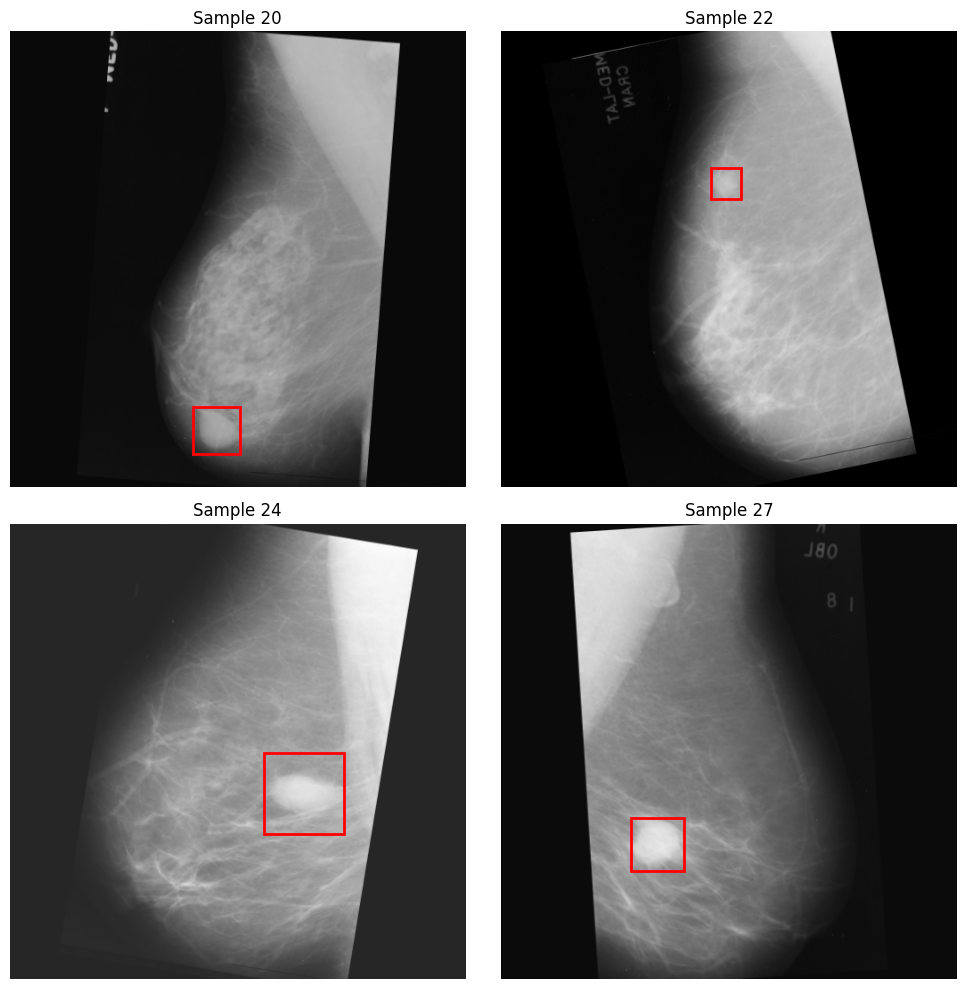

In [27]:
# Test Augmented Data 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

def show_augmented_sample(img, target, ax, title="Augmented Sample"):
    img_np = img.permute(1, 2, 0).cpu().numpy()
    ax.imshow(img_np.astype(np.uint8), cmap='gray')
    
    boxes = target["boxes"]
    for box in boxes:
        x_min, y_min, x_max, y_max = box.tolist()
        width = x_max - x_min
        height = y_max - y_min
        rect = Rectangle((x_min, y_min), width, height,
                         linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    ax.set_title(title)
    ax.axis('off')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
shown = 0
i = 20

while shown < 4 and i < len(dataset):
    img, target = dataset[i]
    if target["boxes"].numel() != 0:
        show_augmented_sample(img * 255, target, axs[shown // 2][shown % 2], title=f"Sample {i}")
        shown += 1
    i += 1

plt.tight_layout()
plt.show()


In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

cpu
[{'boxes': tensor([]), 'labels': tensor([], dtype=torch.int64), 'image_id': tensor([199])}, {'boxes': tensor([]), 'labels': tensor([], dtype=torch.int64), 'image_id': tensor([152])}, {'boxes': tensor([]), 'labels': tensor([], dtype=torch.int64), 'image_id': tensor([146])}, {'boxes': tensor([]), 'labels': tensor([], dtype=torch.int64), 'image_id': tensor([193])}, {'boxes': tensor([]), 'labels': tensor([], dtype=torch.int64), 'image_id': tensor([148])}, {'boxes': tensor([]), 'labels': tensor([], dtype=torch.int64), 'image_id': tensor([254])}, {'boxes': tensor([]), 'labels': tensor([], dtype=torch.int64), 'image_id': tensor([182])}, {'boxes': tensor([]), 'labels': tensor([], dtype=torch.int64), 'image_id': tensor([224])}, {'boxes': tensor([]), 'labels': tensor([], dtype=torch.int64), 'image_id': tensor([43])}, {'boxes': tensor([]), 'labels': tensor([], dtype=torch.int64), 'image_id': tensor([160])}, {'boxes': tensor([[200.2224, 349.7787, 238.0197, 387.5761]]), 'labels': tensor([1]), '

# Model Selection

Currently using an RCNN like the third reference

In [31]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [33]:
# 3 features because using classifying into 3 severities: 
# normal, benign, malignant

model = get_model_instance_segmentation(3)



C:\Users\seren\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\seren\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training

`config` file currently set for

20 epochs

batch size 32

change as necessary in the `config` before running

In [ ]:
num_epochs = config.NUM_EPOCHS
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

        if annotations[0]["boxes"].shape[0] == 0:
            continue
        
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)

tensor(1.1231, grad_fn=<AddBackward0>)
tensor(0.8005, grad_fn=<AddBackward0>)


Epoch 1/20, Loss: 1.0780154602216498
Epoch 2/20, Loss: 0.7330042875328218
Epoch 3/20, Loss: 1.0071775874966988
Epoch 4/20, Loss: 0.8548635568149621
Epoch 5/20, Loss: 0.6323067958146567
Epoch 6/20, Loss: 0.7880547654312977
Epoch 7/20, Loss: 0.8121167690624134
Epoch 8/20, Loss: 1.0380461068998557
Epoch 9/20, Loss: 0.8320490824262379
Epoch 10/20, Loss: 1.2350408295897068
Epoch 11/20, Loss: 0.7322463720483938
Epoch 12/20, Loss: 1.225475948798703
Epoch 13/20, Loss: 0.8440100192310638
Epoch 14/20, Loss: 1.0630208856018726
Epoch 15/20, Loss: 0.8155027620086912
Epoch 16/20, Loss: 1.0718470345018432
Epoch 17/20, Loss: 0.6835208021657309
Epoch 18/20, Loss: 0.9015764417508763
Epoch 19/20, Loss: 0.9014083234360442
Epoch 20/20, Loss: 0.9284518903295975


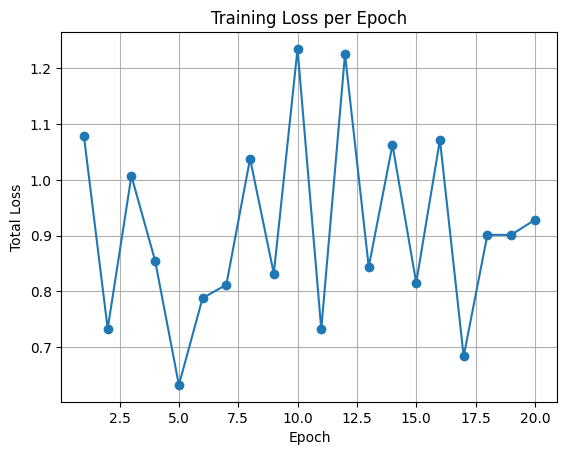

In [36]:
import matplotlib.pyplot as plt

epoch_losses = []  # Store epoch losses

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 

        epoch_loss += losses.item()  # Make sure to use .item() to extract scalar from tensor
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")
    epoch_losses.append(epoch_loss)

# Plotting
plt.figure()
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.show()


# Predictions

In [40]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break


In [42]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  

Prediction


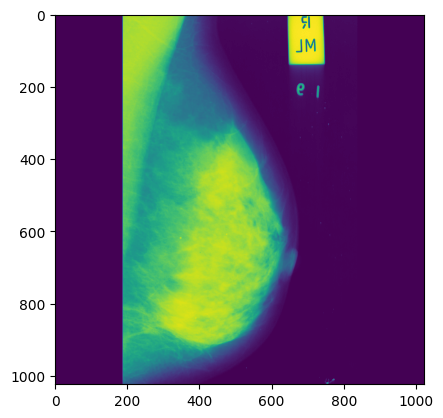

Target


In [44]:
from plotting import plot_image
idx = 3
print("Prediction")
plot_image(imgs[idx], preds[idx])
print("Target")


{'boxes': tensor([], size=(0, 4)), 'labels': tensor([0]), 'image_id': tensor([3])}


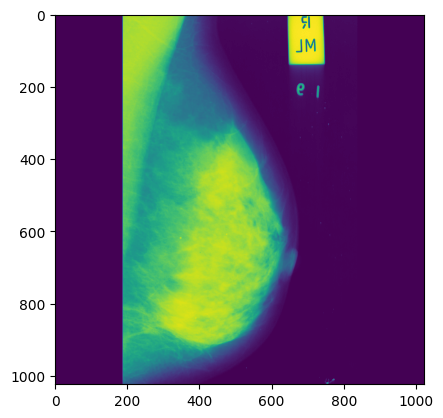

In [46]:
img = imgs[idx]
annot = annotations[idx]
print(annot)
plot_image(imgs[idx], annotations[idx])